# Core project 1
efa o

#### load in libraries and preprocessing tools 

In [1]:
import sklearn
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
from IPython.display import clear_output
clear_output()

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### Load in custom functions. 

In [2]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=11, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [3]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [4]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [5]:
def annotate_hbars(ax, ha='left', va='center', size=11, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)


In [6]:
#Load in data
df = pd.read_csv("/Users/dell/Downloads/sales_predictions.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
sales_df = df

In [8]:
pd.set_option('display.max_columns',0)
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data cleaning

In [9]:
sales_df['Item_Fat_Content'] = sales_df['Item_Fat_Content']. replace({'LF':'Low Fat','reg': 'Regular','low fat': 'Low Fat'})
sales_df.value_counts('Item_Fat_Content')

Item_Fat_Content
Low Fat    5517
Regular    3006
dtype: int64

In [10]:
sales_df['Outlet_Size'] = sales_df['Outlet_Size']. replace('High','Large')
sales_df.value_counts('Outlet_Size')

Outlet_Size
Medium    2793
Small     2388
Large      932
dtype: int64

In [11]:
#function to summarize df
def summarize_df(sales_df_):
    sales_df = sales_df_.copy()
    report = pd.DataFrame({
                        'dtype':df.dtypes,
                        '# null': df.isna().sum(),
                        'null (%)': df.isna().sum()/len(df)*100,
                        'nunique':df.nunique(),
                        "min":df.min(),
                        'max':df.max()
             })
    report.index.name='Column'
    return report.reset_index()
summarize_df(df)

C:\Users\dell\AppData\Local\Temp\ipykernel_20724\3337360808.py:9: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  "min":df.min(),
C:\Users\dell\AppData\Local\Temp\ipykernel_20724\3337360808.py:10: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'max':df.max()


,Column,dtype,# null,null (%),nunique,min,max
0,Item_Fat_Content,object,0,0.000000,2,Low Fat,Regular
1,Item_Identifier,object,0,0.000000,1559,DRA12,NCZ54
2,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
3,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648
4,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
5,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
6,Item_Weight,float64,1463,17.165317,415,4.555,21.35
7,Outlet_Establishment_Year,int64,0,0.000000,9,1985,2009
8,Outlet_Identifier,object,0,0.000000,10,OUT010,OUT049
9,Outlet_Location_Type,object,0,0.000000,3,Tier 1,Tier 3


In [12]:
#splitting data
target= 'Item_Outlet_Sales'
drop_feats= ['Item_Identifier','Outlet_Establishment_Year']
X = sales_df.drop(columns=[target,*drop_feats])
y = sales_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,NaN,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,OUT035,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,Small,Tier 2,Supermarket Type1


In [13]:
#making preprocessor and column transformer
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='constant',fill_value='MISSING')
ohe = OneHotEncoder(drop='if_binary',handle_unknown='ignore',
                                       sparse=False)

numb_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline (freq_imputer, ohe)

cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include = 'number')

category_tuple = (cat_pipe, cat_sel)
numb_tuple = (numb_pipe, num_sel)
preprocessor = make_column_transformer(category_tuple,numb_tuple,verbose_feature_names_out=False,remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001EBE6D95400>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001EBE6D952E0>)],
                  verbose_feature_names_out=False)

In [14]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_Large',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Gr

In [15]:
preprocessor = make_column_transformer((numb_tuple),
                                       (category_tuple),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns= preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,-1.319041,-0.043295,-1.268171,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,-1.574485,0.248066,-0.459996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,-0.158360,-0.726880,0.182616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,0.571480,-0.093503,-0.120626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,1.183604,-0.421698,-0.204533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,-1.307269,0.090081,-0.412092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

In [18]:
lin_reg= LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df,y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.85,"1,115.25"
Test,0.56,860.12,"1,165.01"


In [19]:
lin_reg.coef_

array([ 4.85065284e+00, -1.70414125e+01,  9.65037874e+02,  2.56245406e+01,
       -1.41583655e+15, -1.41583655e+15, -1.41583655e+15, -1.41583655e+15,
       -1.41583655e+15, -1.41583655e+15, -1.41583655e+15, -1.41583655e+15,
       -1.41583655e+15, -1.41583655e+15, -1.41583655e+15, -1.41583655e+15,
       -1.41583655e+15, -1.41583655e+15, -1.41583655e+15, -1.41583655e+15,
        3.66232241e+15,  1.25968892e+15, -5.95129833e+15, -6.13375040e+15,
        1.07634747e+16,  1.14108803e+16,  4.91641769e+15, -5.95129833e+15,
        1.70716726e+16,  1.36065519e+16,  6.96817457e+15, -1.74265680e+15,
       -9.14525216e+15, -1.26103728e+16,  1.39303114e+16,  2.60855662e+16,
        1.01637476e+16, -1.02542179e+16, -1.65624158e+16,  6.94445026e+15,
       -1.06001805e+16])

In [20]:
lin_reg.intercept_

-413358773202288.9

In [21]:
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                        4.850653e+00
Item_Visibility                   -1.704141e+01
Item_MRP                           9.650379e+02
Item_Fat_Content_Regular           2.562454e+01
Item_Type_Baking Goods            -1.415837e+15
Item_Type_Breads                  -1.415837e+15
Item_Type_Breakfast               -1.415837e+15
Item_Type_Canned                  -1.415837e+15
Item_Type_Dairy                   -1.415837e+15
Item_Type_Frozen Foods            -1.415837e+15
Item_Type_Fruits and Vegetables   -1.415837e+15
Item_Type_Hard Drinks             -1.415837e+15
Item_Type_Health and Hygiene      -1.415837e+15
Item_Type_Household               -1.415837e+15
Item_Type_Meat                    -1.415837e+15
Item_Type_Others                  -1.415837e+15
Item_Type_Seafood                 -1.415837e+15
Item_Type_Snack Foods             -1.415837e+15
Item_Type_Soft Drinks             -1.415837e+15
Item_Type_Starchy Foods           -1.415837e+15
Outlet_Identifier_OUT010           3.662

In [22]:
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [23]:
coeffs

Item_Weight                                             4.8507
Item_Visibility                                       -17.0414
Item_MRP                                              965.0379
Item_Fat_Content_Regular                               25.6245
Item_Type_Baking Goods             -1,415,836,554,388,050.5000
Item_Type_Breads                   -1,415,836,554,388,056.2500
Item_Type_Breakfast                -1,415,836,554,387,985.7500
Item_Type_Canned                   -1,415,836,554,388,032.0000
Item_Type_Dairy                    -1,415,836,554,388,091.5000
Item_Type_Frozen Foods             -1,415,836,554,388,067.2500
Item_Type_Fruits and Vegetables    -1,415,836,554,388,033.2500
Item_Type_Hard Drinks              -1,415,836,554,388,004.0000
Item_Type_Health and Hygiene       -1,415,836,554,388,105.5000
Item_Type_Household                -1,415,836,554,388,125.7500
Item_Type_Meat                     -1,415,836,554,388,068.2500
Item_Type_Others                   -1,415,836,554,388,0

In [24]:
sales_df.select_dtypes('object').nunique()

Item_Identifier         1559
Item_Fat_Content           2
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [25]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Location_Type_Tier 2       42.0000
Outlet_Identifier_OUT046          41.0000
Outlet_Type_Supermarket Type1     40.0000
Outlet_Location_Type_Tier 1       39.0000
Outlet_Identifier_OUT049          38.0000
Outlet_Size_Small                 37.0000
Outlet_Identifier_OUT027          36.0000
Outlet_Identifier_OUT019          35.0000
Outlet_Type_Supermarket Type3     34.0000
Outlet_Type_Grocery Store         33.0000
Outlet_Location_Type_Tier 3       32.0000
Outlet_Size_Medium                31.0000
Outlet_Size_Large                 30.0000
Outlet_Type_Supermarket Type2     29.0000
Outlet_Identifier_OUT018          28.0000
Outlet_Identifier_OUT045          27.0000
Outlet_Identifier_OUT017          26.0000
Outlet_Identifier_OUT035          25.0000
Outlet_Identifier_OUT010          24.0000
Outlet_Size_MISSING               23.0000
Item_Type_Soft Drinks             22.0000
Item_Type_Household               21.0000
Item_Type_Health and Hygiene      20.0000
Item_Type_Dairy                   

In [26]:
top_n_features = coeff_rank.head(10)
top_n_features

Outlet_Location_Type_Tier 2     42.0000
Outlet_Identifier_OUT046        41.0000
Outlet_Type_Supermarket Type1   40.0000
Outlet_Location_Type_Tier 1     39.0000
Outlet_Identifier_OUT049        38.0000
Outlet_Size_Small               37.0000
Outlet_Identifier_OUT027        36.0000
Outlet_Identifier_OUT019        35.0000
Outlet_Type_Supermarket Type3   34.0000
Outlet_Type_Grocery Store       33.0000
dtype: float64

In [27]:
plot_vals = coeffs[top_n_features.index]
plot_vals

Outlet_Location_Type_Tier 2      26,085,566,229,045,636.0000
Outlet_Identifier_OUT046         17,071,672,556,909,728.0000
Outlet_Type_Supermarket Type1   -16,562,415,776,203,718.0000
Outlet_Location_Type_Tier 1      13,930,311,360,866,674.0000
Outlet_Identifier_OUT049         13,606,551,902,381,064.0000
Outlet_Size_Small               -12,610,372,813,980,082.0000
Outlet_Identifier_OUT027         11,410,880,334,032,572.0000
Outlet_Identifier_OUT019         10,763,474,688,825,006.0000
Outlet_Type_Supermarket Type3   -10,600,180,468,797,778.0000
Outlet_Type_Grocery Store       -10,254,217,908,120,908.0000
dtype: float64

In [28]:
top_n = 10
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

Outlet_Type_Supermarket Type1   -16,562,415,776,203,718.0000
Outlet_Size_Small               -12,610,372,813,980,082.0000
Outlet_Type_Supermarket Type3   -10,600,180,468,797,778.0000
Outlet_Type_Grocery Store       -10,254,217,908,120,908.0000
Outlet_Identifier_OUT019         10,763,474,688,825,006.0000
Outlet_Identifier_OUT027         11,410,880,334,032,572.0000
Outlet_Identifier_OUT049         13,606,551,902,381,064.0000
Outlet_Location_Type_Tier 1      13,930,311,360,866,674.0000
Outlet_Identifier_OUT046         17,071,672,556,909,728.0000
Outlet_Location_Type_Tier 2      26,085,566,229,045,636.0000
dtype: float64

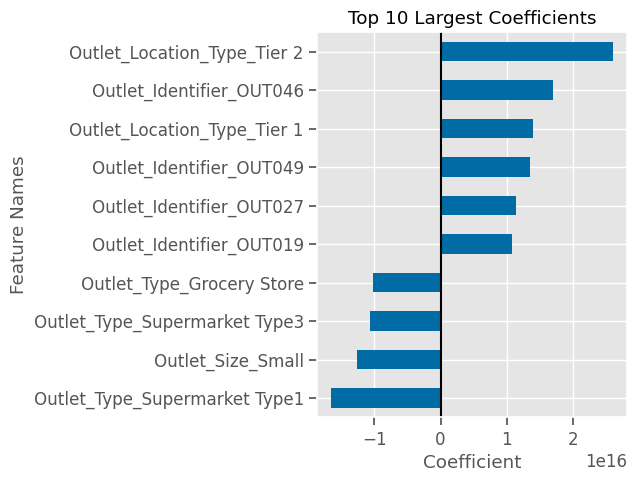

In [29]:
ax= plot_coeffs(coeffs,top_n=10, intercept=False)

In [30]:
print(type(ax.patches))
print(len(ax.patches))
ax.patches[0]

<class 'list'>
10


In [31]:
bar = ax.patches[0]
bar.get_height()

0.5

In [32]:
bar.get_width()

-1.6562415776203718e+16

In [33]:
bar.get_x()

0

In [34]:
bar.get_y()

-0.25

In [35]:
bar_ax = bar.get_y() + bar.get_height()/2
bar_ax

0.0

In [36]:
val = bar.get_width()
val

-1.6562415776203718e+16

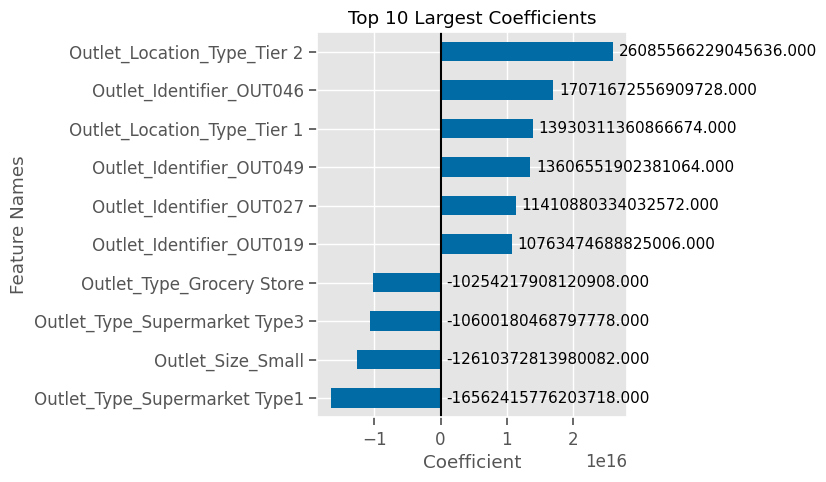

In [37]:
ax = plot_coeffs(coeffs,top_n=10)
annotate_hbars(ax)

### Interpretations
Intercept baseline is 32.0000

### Coefficients that positively influenced sales 
items from outlet location type 2 increased sales(target) by 26,085,566,229,045,636.0000 

outlet identifier 046 increased sales by 17,071,672,556,909,728.0000

items at Outlet_Location_Type_Tier 1 increased sales by      13,930,311,360,866,674.0000

Outlet_Identifier_OUT049 increased sales by         13,606,551,902,381,064.0000

Outlet_Identifier_OUT027 increased sales by         11,410,880,334,032,572.0000

Outlet_Identifier_OUT019   increased sales by 
10,763,474,688,825,006.0000

### neg impact coefficients 

items from Outlet_Type_Supermarket Type1 decreased sales by  -16,562,415,776,203,718.0000


items from Outlet_Size_Small  decreased sales             -12,610,372,813,980,082.0000


items from Outlet_Type_Supermarket Type3  decreased sales by  -10,600,180,468,797,778.0000

items from Outlet_Type_Grocery Store  also decreased sales by      -10,254,217,908,120,908.0000
accoring to this model. 


### Tree model fitting 

In [38]:
ran_for = RandomForestRegressor(random_state=SEED)
ran_for.fit(X_train_df,y_train)
evaluate_regression(ran_for, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,292.98,424.56
Test,0.56,816.86,"1,165.87"


In [39]:
#get feature importance( seems a bit overfit)
ran_for.feature_importances_

array([5.35403529e-02, 9.81396710e-02, 4.44849706e-01, 8.33522140e-03,
       4.44608121e-03, 2.86736750e-03, 2.53459850e-03, 4.29171811e-03,
       5.47972271e-03, 5.90352543e-03, 8.41925400e-03, 3.04374810e-03,
       4.22359153e-03, 6.22826692e-03, 3.60455015e-03, 1.67285739e-03,
       1.37840059e-03, 8.17564606e-03, 4.08239879e-03, 3.06367922e-03,
       1.27004133e-05, 2.34601385e-03, 4.62473889e-03, 1.59647327e-03,
       1.34204259e-05, 3.51387251e-02, 4.65099423e-03, 5.66067700e-03,
       3.90709094e-03, 3.75029645e-03, 2.54676541e-03, 3.64831283e-03,
       3.31797437e-03, 4.58671751e-03, 3.85333112e-03, 3.97321866e-03,
       3.24179076e-03, 1.96758190e-01, 2.83127658e-03, 1.54311636e-03,
       3.77178187e-02])

In [40]:
imp_feat = pd.Series(ran_for.feature_importances_, index= feature_names,
                       name='Feature Importance')
imp_feat

Item_Fat_Content_Regular          0.0535
Item_Type_Baking Goods            0.0981
Item_Type_Breads                  0.4448
Item_Type_Breakfast               0.0083
Item_Type_Canned                  0.0044
Item_Type_Dairy                   0.0029
Item_Type_Frozen Foods            0.0025
Item_Type_Fruits and Vegetables   0.0043
Item_Type_Hard Drinks             0.0055
Item_Type_Health and Hygiene      0.0059
Item_Type_Household               0.0084
Item_Type_Meat                    0.0030
Item_Type_Others                  0.0042
Item_Type_Seafood                 0.0062
Item_Type_Snack Foods             0.0036
Item_Type_Soft Drinks             0.0017
Item_Type_Starchy Foods           0.0014
Outlet_Identifier_OUT010          0.0082
Outlet_Identifier_OUT013          0.0041
Outlet_Identifier_OUT017          0.0031
Outlet_Identifier_OUT018          0.0000
Outlet_Identifier_OUT019          0.0023
Outlet_Identifier_OUT027          0.0046
Outlet_Identifier_OUT035          0.0016
Outlet_Identifie

In [41]:
sorted_importance = imp_feat.sort_values()
sorted_importance

Outlet_Identifier_OUT018          0.0000
Outlet_Identifier_OUT045          0.0000
Item_Type_Starchy Foods           0.0014
Item_Visibility                   0.0015
Outlet_Identifier_OUT035          0.0016
Item_Type_Soft Drinks             0.0017
Outlet_Identifier_OUT019          0.0023
Item_Type_Frozen Foods            0.0025
Outlet_Size_Small                 0.0025
Item_Weight                       0.0028
Item_Type_Dairy                   0.0029
Item_Type_Meat                    0.0030
Outlet_Identifier_OUT017          0.0031
Outlet_Type_Supermarket Type2     0.0032
Outlet_Location_Type_Tier 2       0.0033
Item_Type_Snack Foods             0.0036
Outlet_Location_Type_Tier 1       0.0036
Outlet_Size_Medium                0.0038
Outlet_Type_Grocery Store         0.0039
Outlet_Size_MISSING               0.0039
Outlet_Type_Supermarket Type1     0.0040
Outlet_Identifier_OUT013          0.0041
Item_Type_Others                  0.0042
Item_Type_Fruits and Vegetables   0.0043
Item_Type_Canned

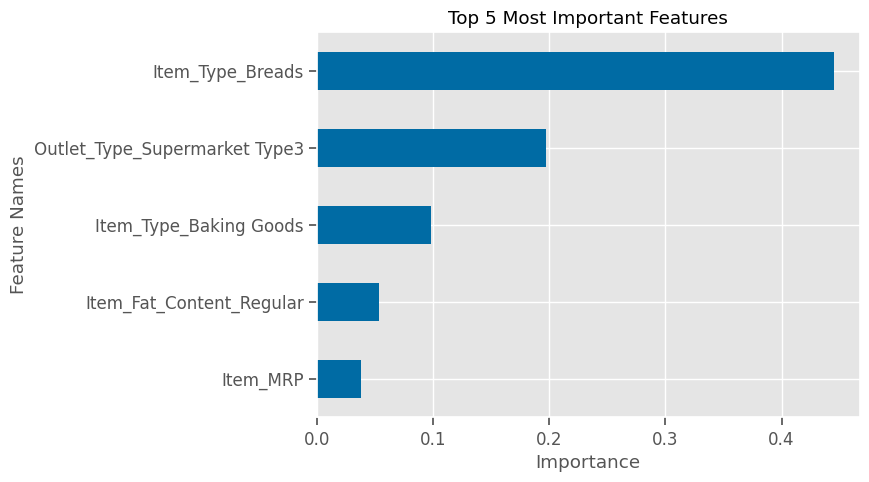

In [42]:
ax = sorted_importance.tail(5).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');

## the top 5 features are 
1. item type (breakfast) 
2. Item type bread
3. Item weight
4. Items with regular fat content
5. items market retail price


In [43]:
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':ran_for,
         'LinearRegression':lin_reg}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']